# PPO Rotation Alignment Agent (Kornia + PyTorch)

This notebook trains a minimal PPO agent on the same synthetic rotation/mirror dataset used in `dqn.ipynb`.
We use Stable-Baselines3's baseline PPO implementation and keep everything intentionally barebones.


In [91]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [92]:
import math
import random
from typing import Callable, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import kornia as K

import gymnasium as gym

from stable_baselines3 import PPO


In [93]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def build_state(source: torch.Tensor, target: torch.Tensor, angle_deg=None) -> torch.Tensor:
    # Build state by concatenating source, target, and a constant angle channel.
    # Handles batch expansion of target/angle if needed.
    if source.dim() == 3:
        source = source.unsqueeze(0)
    if target.dim() == 3:
        target = target.unsqueeze(0)
    if target.shape[0] == 1 and source.shape[0] > 1:
        target = target.expand(source.shape[0], -1, -1, -1)

    state = torch.cat([source, target], dim=1)

    if angle_deg is None:
        return state

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=state.device, dtype=state.dtype)
    else:
        angle = angle_deg.to(device=state.device, dtype=state.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and state.shape[0] > 1:
        angle = angle.repeat(state.shape[0])

    angle_norm = (angle % 360.0) / 360.0
    angle_ch = angle_norm.view(-1, 1, 1, 1).expand(-1, 1, state.shape[2], state.shape[3])
    return torch.cat([state, angle_ch], dim=1)


def rotate_tensor(img: torch.Tensor, angle_deg, pad_to_diag: bool = True) -> torch.Tensor:
    # Rotate image(s) by angle(s) in degrees using kornia.
    # If pad_to_diag=True, pad to the diagonal size before rotating, then center-crop.
    if img.dim() == 3:
        img_b = img.unsqueeze(0)
    else:
        img_b = img

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=img_b.device, dtype=img_b.dtype)
    else:
        angle = angle_deg.to(device=img_b.device, dtype=img_b.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and img_b.shape[0] > 1:
        angle = angle.repeat(img_b.shape[0])

    b, c, h, w = img_b.shape
    if pad_to_diag:
        diag = int(math.ceil(math.sqrt(h * h + w * w)))
        pad_h = max(0, diag - h)
        pad_w = max(0, diag - w)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        if pad_h > 0 or pad_w > 0:
            img_p = F.pad(img_b, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0.0)
        else:
            img_p = img_b
    else:
        img_p = img_b

    rotated = K.geometry.transform.rotate(img_p, angle)

    if pad_to_diag:
        hh, ww = h, w
        y0 = (rotated.shape[2] - hh) // 2
        x0 = (rotated.shape[3] - ww) // 2
        rotated = rotated[:, :, y0:y0 + hh, x0:x0 + ww]

    return rotated if img.dim() == 4 else rotated.squeeze(0)


device = get_device()
print("Device:", device)


Device: mps


Next, we recreate the **same synthetic dataset** as the DQN notebook: colored rectangles on a black background.
The source image is either a rotated copy of the target (match) or a mirrored + rotated version (mismatch).


In [94]:
def random_target_image(h: int, w: int, num_shapes: int = 4) -> torch.Tensor:
    img = torch.zeros(3, h, w)
    for _ in range(num_shapes):
        color = torch.rand(3, 1, 1)
        y0 = random.randint(0, h - 8)
        x0 = random.randint(0, w - 8)
        y1 = min(h, y0 + random.randint(6, h // 2))
        x1 = min(w, x0 + random.randint(6, w // 2))
        img[:, y0:y1, x0:x1] = color
    return img


def make_pair_sampler(
    image_shape: Tuple[int, int, int],
    mirror_prob: float = 0.5,
    angle_step: float = 5.0,
) -> Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]:
    _, h, w = image_shape

    def sampler(device: torch.device):
        target = random_target_image(h, w)
        is_mirrored = random.random() < mirror_prob
        source = torch.flip(target, dims=[2]) if is_mirrored else target.clone()
        angle = random.choice(np.arange(0.0, 360.0, angle_step))
        source = rotate_tensor(source, angle)
        return source, target, is_mirrored

    return sampler


Now we define the Gymnasium environment. It's the same action space and reward logic as in `dqn.ipynb`,
just adapted to return **NumPy observations** so Stable-Baselines3 can consume them.


In [95]:
class RotationEnv(gym.Env):
    # Observation: (7, H, W) = [source(3), target(3), angle(1)] in [0, 1]
    # Actions:
    #   0: rotate CW  (delta = -30 deg)
    #   1: rotate CCW (delta = +30 deg)
    #   2: rotate CW  (delta = -15 deg)
    #   3: rotate CCW (delta = +15 deg)
    #   4: rotate CW  (delta = -2 deg)
    #   5: rotate CCW (delta = +2 deg)
    #   6: commit match (uses best error; bonus if error is tiny)
    #   7: commit mismatch (only allowed after N steps without improvement; uses best error)
    #   8: rotate 180 deg (flip)

    metadata = {"render_modes": []}

    def __init__(
        self,
        image_shape: Tuple[int, int, int],
        max_steps: int = 180,
        max_total_rotation: float = 360.0,
        epsilon: float = 0.03,
        commit_bonus: float = 20.0,
        commit_bonus_eps: Optional[float] = None,
        mismatch_patience: int = 15,
        improve_eps: float = 1e-6,
        device: Optional[torch.device] = None,
        pair_sampler: Optional[Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]] = None,
    ):
        super().__init__()
        self.image_shape = image_shape  # (3, H, W)
        self.max_steps = max_steps
        self.max_total_rotation = float(max_total_rotation)
        self.epsilon = epsilon
        self.commit_bonus = commit_bonus
        self.commit_bonus_eps = commit_bonus_eps if commit_bonus_eps is not None else 0.5 * epsilon
        self.mismatch_patience = mismatch_patience
        self.improve_eps = improve_eps
        self.device = device or get_device()
        self.pair_sampler = pair_sampler

        _, h, w = image_shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(7, h, w),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(9)

        self.base_source = None
        self.target = None
        self.current_source = None
        self.current_angle = 0.0
        self.is_mirrored = False
        self.step_count = 0
        self.total_rotation = 0.0
        self.prev_error = None
        self.best_error = None
        self.best_angle = 0.0
        self.no_improve_steps = 0

    def _set_pair(self, source: torch.Tensor, target: torch.Tensor, is_mirrored: bool) -> None:
        self.base_source = source.to(self.device).float().clamp(0, 1)
        self.target = target.to(self.device).float().clamp(0, 1)
        self.is_mirrored = bool(is_mirrored)
        self.current_angle = 0.0
        self.current_source = self.base_source
        self.step_count = 0
        self.total_rotation = 0.0
        self.prev_error = self._alignment_error().detach()
        self.best_error = self.prev_error
        self.best_angle = self.current_angle
        self.no_improve_steps = 0

    def _obs(self) -> np.ndarray:
        state = build_state(self.current_source, self.target, self.current_angle)[0]
        return state.detach().cpu().numpy().astype(np.float32)

    def _alignment_error(self) -> torch.Tensor:
        return torch.mean((self.current_source - self.target) ** 2)

    def _update_no_improve(self, err: torch.Tensor) -> None:
        if err < (self.prev_error - self.improve_eps):
            self.no_improve_steps = 0
        else:
            self.no_improve_steps += 1
        self.prev_error = err.detach()

    def _update_best(self, err: torch.Tensor) -> None:
        if self.best_error is None or err < self.best_error:
            self.best_error = err.detach()
            self.best_angle = self.current_angle

    def _apply_rotation(self, delta: float) -> None:
        self.current_angle = (self.current_angle + delta) % 360.0
        self.total_rotation += abs(delta)
        self.current_source = rotate_tensor(self.base_source, self.current_angle)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        options = options or {}

        if "pair" in options:
            source, target, is_mirrored = options["pair"]
        elif "source" in options and "target" in options:
            source = options["source"]
            target = options["target"]
            is_mirrored = bool(options.get("is_mirrored", False))
        elif self.pair_sampler is not None:
            source, target, is_mirrored = self.pair_sampler(self.device)
        else:
            raise ValueError("No pair provided. Pass options={pair: (...)} or set pair_sampler.")

        self._set_pair(source, target, is_mirrored)
        info = {"angle": self.current_angle}
        return self._obs(), info

    def step(self, action: int):
        terminated = False
        reward = 0.0
        err = self._alignment_error()

        if action == 0 or action == 1:
            delta = -30.0 if action == 0 else 30.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 2 or action == 3:
            delta = -15.0 if action == 2 else 15.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 4 or action == 5:
            delta = -2.0 if action == 4 else 2.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 8:
            delta = 180.0
            self._apply_rotation(delta)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_best(err)
            self._update_no_improve(err)
        elif action == 6:
            best_err = float(self.best_error.detach()) if self.best_error is not None else float(err.detach())
            if best_err < self.epsilon:
                is_match = (not self.is_mirrored)
                reward = 100.0 if is_match else -100.0
                if is_match and best_err < self.commit_bonus_eps:
                    reward += self.commit_bonus
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        elif action == 7:
            if self.no_improve_steps >= self.mismatch_patience:
                best_err = float(self.best_error.detach()) if self.best_error is not None else float(err.detach())
                is_mismatch = self.is_mirrored and (best_err >= self.epsilon)
                reward = 100.0 if is_mismatch else -100.0
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        else:
            raise ValueError(f"Invalid action: {action}")

        self.step_count += 1
        truncated = (self.step_count >= self.max_steps) and (not terminated)
        if self.total_rotation >= self.max_total_rotation and not terminated:
            truncated = True

        info = {
            "angle": self.current_angle,
            "error": float(err.detach().cpu()),
            "best_error": float(self.best_error.detach().cpu()) if self.best_error is not None else float(err.detach().cpu()),
            "best_angle": float(self.best_angle),
            "is_mirrored": self.is_mirrored,
            "no_improve_steps": self.no_improve_steps,
            "total_rotation": float(self.total_rotation),
        }
        return self._obs(), float(reward), terminated, truncated, info


With the environment in place, we can plug in **Stable-Baselines3 PPO** directly. This mirrors the baseline
usage from the SB3 docs. We keep hyperparameters default for now (except total timesteps), which is the
simplest usable PPO setup.

Because our observations are already normalized to `[0, 1]` floats, we disable SB3's image normalization
(`normalize_images=False`) to satisfy the CNN policy's input checks. We also log training metrics to CSV
so we can plot common PPO loss components after training.


In [96]:
set_seed(0)

H, W = 64, 64
image_shape = (3, H, W)

sampler = make_pair_sampler(image_shape=image_shape, mirror_prob=0.5, angle_step=5.0)

env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    device="auto",
    learning_rate=2e-4,
    policy_kwargs={"normalize_images": False},
)

# Log to CSV so we can plot PPO losses later
from stable_baselines3.common.logger import configure
log_dir = "logs/ppo_rotation"
logger = configure(log_dir, ["stdout", "csv"])
model.set_logger(logger)

# Train (increase total_timesteps for better performance)
model.learn(total_timesteps=50_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo_rotation
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.9     |
|    ep_rew_mean     | 6.03     |
| time/              |          |
|    fps             | 55       |
|    iterations      | 1        |
|    time_elapsed    | 36       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 2          |
|    time_elapsed         | 90         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.09573455 |
|    clip_fraction        | 0.422      |
|    clip_range           | 0.2        |
|   

In [97]:
import numpy as np

n_eval_episodes = 10
success = 0
rewards = []

for _ in range(n_eval_episodes):
    obs, _ = env.reset()
    terminated = False
    truncated = False
    ep_reward = 0.0
    last_reward = 0.0

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        ep_reward += float(reward)
        last_reward = float(reward)

    rewards.append(ep_reward)
    if terminated and last_reward > 0:
        success += 1

print(f"Mean episode reward: {np.mean(rewards):.2f}")
print(f"Success rate: {success / n_eval_episodes:.2%}")


Mean episode reward: -4.99
Success rate: 10.00%


Plot raw MSE at commit time to diagnose incorrect commits. We compare the best MSE achieved in an episode
for correct vs incorrect commits.


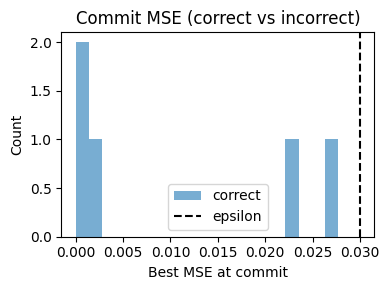

In [99]:
import matplotlib.pyplot as plt

if 'eval_env' not in globals():
    eval_env = RotationEnv(
        image_shape=image_shape,
        max_steps=180,
        epsilon=0.03,
        device=device,
        pair_sampler=sampler,
    )

n_diag = 50
errs_correct = []
errs_wrong = []

for _ in range(n_diag):
    obs, _ = eval_env.reset()
    terminated = False
    truncated = False
    last_reward = 0.0
    last_info = {}

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(int(action))
        last_reward = float(reward)
        last_info = info

    if terminated:
        best_err = last_info.get('best_error', last_info.get('error', None))
        if best_err is not None:
            if last_reward > 0:
                errs_correct.append(best_err)
            else:
                errs_wrong.append(best_err)

plt.figure(figsize=(4, 3))
if errs_correct:
    plt.hist(errs_correct, bins=20, alpha=0.6, label='correct')
if errs_wrong:
    plt.hist(errs_wrong, bins=20, alpha=0.6, label='incorrect')
plt.axvline(eval_env.epsilon, color='k', linestyle='--', label='epsilon')
plt.xlabel('Best MSE at commit')
plt.ylabel('Count')
plt.title('Commit MSE (correct vs incorrect)')
plt.legend()
plt.tight_layout()
plt.show()


Plot common PPO loss components from the CSV log. This gives a quick view of how the
policy loss, value loss, entropy, and total loss evolve across training iterations.


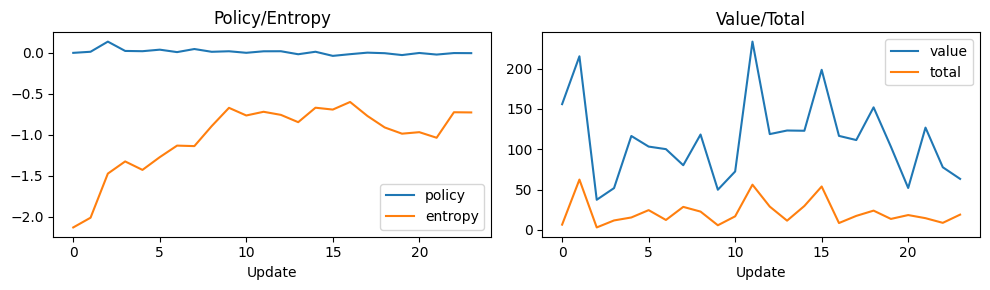

In [101]:
import csv
import os

log_path = os.path.join(log_dir, "progress.csv")
if not os.path.exists(log_path):
    print(f"No progress.csv found at {log_path}. Did training run?")
else:
    with open(log_path, "r", newline="") as f:
        rows = list(csv.DictReader(f))

    def get_series(key: str):
        vals = []
        for r in rows:
            v = r.get(key, "")
            if v != "" and v is not None:
                vals.append(float(v))
        return vals

    policy_loss = get_series("train/policy_gradient_loss")
    value_loss = get_series("train/value_loss")
    entropy_loss = get_series("train/entropy_loss")
    total_loss = get_series("train/loss")

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    if policy_loss:
        axes[0].plot(policy_loss, label="policy")
    if entropy_loss:
        axes[0].plot(entropy_loss, label="entropy")
    axes[0].set_title("Policy/Entropy")
    axes[0].set_xlabel("Update")
    axes[0].legend()

    if value_loss:
        axes[1].plot(value_loss, label="value")
    if total_loss:
        axes[1].plot(total_loss, label="total")
    axes[1].set_title("Value/Total")
    axes[1].set_xlabel("Update")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


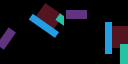

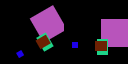

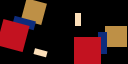

['gifs/rotation_ppo_episode_sample_1.gif',
 'gifs/rotation_ppo_episode_sample_2.gif',
 'gifs/rotation_ppo_episode_sample_3.gif']

In [107]:
import imageio.v2 as imageio
import time
from IPython.display import Image, display

def render_pair_frame(source: torch.Tensor, target: torch.Tensor) -> np.ndarray:
    # Return a side-by-side frame (H, 2W, 3) as uint8.
    src = (source.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    tgt = (target.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    return np.concatenate([src, tgt], axis=1)

def rollout_and_save_gif(
    env: RotationEnv,
    model: PPO,
    out_path: str = "gifs/rotation_ppo_episode.gif",
    seed: Optional[int] = None,
    max_steps: int = 360,
    fps: int = 8,
):
    if seed is not None:
        set_seed(seed)
    obs, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(render_pair_frame(env.current_source, env.target))
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(int(action))
        if terminated or truncated:
            frames.append(render_pair_frame(env.current_source, env.target))
            break

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path

gif_env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.03,
    device=device,
    pair_sampler=sampler,
)

gif_paths = []
base_seed = int(time.time()) % 1000000
for i in range(3):
    out_path = f"gifs/rotation_ppo_episode_sample_{i+1}.gif"
    gif_paths.append(rollout_and_save_gif(gif_env, model, out_path=out_path, seed=base_seed + i))

for p in gif_paths:
    display(Image(filename=p))

gif_paths